# Visualizacion varias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import namedtuple
from scipy import stats
import seaborn as sns
import geopandas as gpd
import matplotlib
import ipywidgets as widgets
from ipywidgets import interact
matplotlib.style.use("ggplot")
import folium
from folium.plugins import DualMap 
import mapas
from shapely.geometry import Polygon, MultiPolygon

## Evolucion de genero en grupo de carreras

In [2]:
df_evolucion_carreras = pd.read_csv('data/output/carreras_evolucion_genero.csv',delimiter=',')

In [3]:
variables_carreras = df_evolucion_carreras.carrera_grupo.unique()

In [4]:
@interact(carrera_grupo = sorted(variables_carreras))
def generate_chart_evolucion_carreras(carrera_grupo):
    serie_grupo_carrera = df_evolucion_carreras[df_evolucion_carreras.carrera_grupo == carrera_grupo][[
        "anio","estudiantes_mujeres_pct"
    ]]
    return serie_grupo_carrera.set_index("anio").plot()
    
#agregar mas de un filtro para ir comparando
#modificar en ETL abogacia y derecho
#apertura por carreras para entender donde hace el pico y decrecimiento tech - cambiar pKEY por carrera y grupo carrera - grafico exploratorio
#segunda tabla de ETL donde haya grupo carrera (carrera) + universidades
#grafico con valores absolutos - apilados o algo que represente orden de magnitud año por default 

interactive(children=(Dropdown(description='carrera_grupo', options=('Abogado', 'Arquitectura', 'Arte', 'Depor…

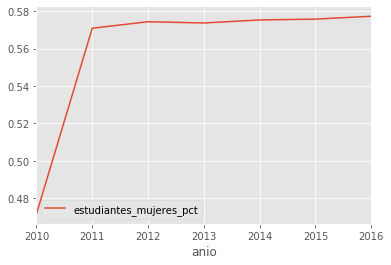

In [5]:
generate_chart_evolucion_carreras("Abogado")

## Mapa universidades

In [6]:
df_universidades = pd.read_csv('data/output/universidades.csv',delimiter=',')
df_universidades

,institucion_nombre,institucion_direccion,api,coordenadas,lat,lon,departamento_id,departamento_nombre,latitud,longitud,municipio_id,municipio_nombre,provincia_id,provincia_nombre,carrera_grupo,carrera_nombre
0,Universidad CAECE,Av. de Mayo 866,http://apis.datos.gob.ar/georef/api/direccione...,"-34.608865810462795,-58.378716306442456",-34.608866,-58.378716,2007,Comuna 1,-34.608866,-58.378716,NaN,NaN,2,Ciudad Autónoma de Buenos Aires,"Economicas,Psicologia,Ingenieria,Exactas,Tecno...","Gestion y Administracion de Empresas,Higiene y..."
1,Universidad Nacional de Córdoba,Av. Haya de la Torre s/n,http://apis.datos.gob.ar/georef/api/direccione...,"-31.4354809,-64.1877589",-31.435481,-64.187759,14014,Capital,-31.435481,-64.187759,140077.0,Córdoba,14,Córdoba,NaN,NaN
2,Universidad Nacional de Rosario,Maipú 1065,http://apis.datos.gob.ar/georef/api/direccione...,"-32.950309649805945,-60.636126952347716",-32.950310,-60.636127,82084,Rosario,-32.950310,-60.636127,NaN,NaN,82,Santa Fe,"Economicas,Psicologia,Ingenieria,Exactas,Tecno...","Ingenieria Vial,Gestion y Administracion de Em..."
3,Universidad Nacional de Río Cuarto,Ruta Nac. 36 - Km. 601,http://apis.datos.gob.ar/georef/api/direccione...,"-33.084594014186514,-64.3349444221352",-33.084594,-64.334944,14098,Río Cuarto,-33.084594,-64.334944,140861.0,Río Cuarto,14,Córdoba,NaN,NaN
4,Universidad Nacional de San Juan,Mitre 396,http://apis.datos.gob.ar/georef/api/direccione...,"-31.5354691,-68.5412352,15",-31.535469,-68.541235,70028,Capital,-31.535469,-68.541235,700028.0,San Juan,70,San Juan,"Economicas,Ingenieria,Exactas,Tecnologia,Arte,...","Ingenieria Vial,Gestion y Administracion de Em..."
5,Universidad Nacional de San Luis,Ejército de los Andes 950,http://apis.datos.gob.ar/georef/api/direccione...,"-33.2962223,-66.3441194",-33.296222,-66.344119,74056,Juan Martín de Pueyrredón,-33.296222,-66.344119,740133.0,San Luis,74,San Luis,"Economicas,Psicologia,Ingenieria,Exactas,Tecno...","Ingenieria Vial,Gestion y Administracion de Em..."
6,Universidad Nacional del Comahue,Av. Santa Fe 1845,http://apis.datos.gob.ar/georef/api/direccione...,"-34.59583822943477,-58.393932130303796",-34.595838,-58.393932,2014,Comuna 2,-34.595838,-58.393932,NaN,NaN,2,Ciudad Autónoma de Buenos Aires,"Economicas,Psicologia,Ingenieria,Exactas,Tecno...","Gestion y Administracion de Empresas,Ingenieri..."
7,Universidad Nacional del Sur,Av. Alem 1253,http://apis.datos.gob.ar/georef/api/direccione...,"-38.67866305629395,-62.29611089500422",-38.678663,-62.296111,6056,Bahía Blanca,-38.678663,-62.296111,60056.0,Bahía Blanca,6,Buenos Aires,"Economicas,Ingenieria,Exactas,Tecnologia,Arte,...","Ingenieria Agronomica,Gestion y Administracion..."
8,Universidad de Buenos Aires,Viamonte 430,http://apis.datos.gob.ar/georef/api/direccione...,"-34.59971093266858,-58.37308898582941",-34.599711,-58.373089,2007,Comuna 1,-34.599711,-58.373089,NaN,NaN,2,Ciudad Autónoma de Buenos Aires,"Economicas,Psicologia,Ingenieria,Exactas,Tecno...","Ingenieria Vial,Higiene y Seguridad Industrial..."
9,Universidad Católica de Salta,Av. Presidente Roque Sáenz Peña 950,http://apis.datos.gob.ar/georef/api/direccione...,"-24.7399552,-65.3940334",-24.739955,-65.394033,66028,Capital,-24.739955,-65.394033,660063.0,Salta,66,Salta,NaN,NaN


In [7]:
argentina_coords = [-40, -64]
osm_no_labels = "https://tiles.wmflabs.org/osm-no-labels/{z}/{x}/{y}.png"
ign_labels = "http://wms.ign.gob.ar/geoserver/gwc/service/tms/1.0.0/capabaseargenmap@EPSG%3A3857@png/{z}/{x}/{y}.png"

In [8]:
mapa = folium.Map(location=argentina_coords, zoom_start=4)
folium.TileLayer(ign_labels, tms=True, attr="IGN").add_to(mapa)
mapa

In [9]:
def mapear_universidades(mapa, df, lat_col, lon_col, institucion_nombre_col, carreras_grupos_col):
    """ cargar informacion al marker de forma masiva.

        Args:
            lat (float): latitud
            lon (float): longuitud
            institucion_nombre (str): nombre de la universidad
            carreras_grupos (list): lista con las areas de estudios ofrecidas

        """
    

In [10]:
mapear_universidades(mapa,df_universidades,"lat","lon","institucion_nombre","carrera_grupo")

In [11]:
mapas.crear_marker(mapa,-40, -64,"UBA",["Tech","abogacia","economia"])
#filtrar por grupo de carrera o despintar los markers segun el color

In [12]:
mapa

In [13]:
mapa = folium.Map(location=argentina_coords, zoom_start=4)
folium.TileLayer(ign_labels, tms=True, attr="IGN").add_to(mapa)
mapa

In [29]:
df_evolucion_ubicacion_test = pd.read_csv('data/output/ubicacion_evolucion_genero_test.csv',
                                          delimiter=',', dtype={'provincia_id': str})
#revisar etl no perder el str de los numeros

df_evolucion_ubicacion_test['provincia_id'] = df_evolucion_ubicacion_test.provincia_id.str.zfill(2)

In [30]:
df_evolucion_ubicacion_test

,anio,provincia_id,carrera_grupo,estudiantes_total,estudiantes_varones,estudiantes_mujeres,nuevos_inscriptos_total,nuevos_inscriptos_varones,nuevos_inscriptos_mujeres,egresados_total,egresados_varones,egresados_mujeres,estudiantes_mujeres_pct
0,2010,02,Tecnologia,10421,8827,1594,2503,2066,437,717,598,119,0.152960
1,2010,06,Tecnologia,13128,10474,2654,3111,2580,531,339,280,59,0.202163
2,2010,10,Tecnologia,840,607,233,230,173,57,12,10,2,0.277381
3,2010,14,Tecnologia,911,796,115,577,500,77,13,13,0,0.126235
4,2010,22,Tecnologia,2042,1441,601,466,384,82,134,78,56,0.294319
5,2010,26,Tecnologia,824,639,185,268,217,51,33,23,10,0.224515
6,2010,30,Tecnologia,117,108,9,17,15,2,8,6,2,0.076923
7,2010,34,Tecnologia,29,19,10,0,0,0,14,8,6,0.344828
8,2010,38,Tecnologia,1913,1373,540,458,358,100,25,20,5,0.282279
9,2010,42,Tecnologia,291,224,67,110,86,24,16,14,2,0.230241


In [31]:
mapa_test = folium.Map(location=argentina_coords, zoom_start=4)

folium.Choropleth(
    geo_data="data/input/provincias.geojson", # la capa de provincias en GeoJson
    data=df_evolucion_ubicacion_test, # DataFrame con los datos a graficar
    columns=['provincia_id', 'estudiantes_mujeres_pct'], # columna con id de geometrías, columna con el dato
    key_on='feature.properties.id', # campo del geojson que tiene el id de las geometrías
    fill_color='YlGn', # escala de colores a usar
    #fill_opacity=0.7, # opacidad del color de relleno
    #line_opacity=0.2, # opacidad de las líneas que separan los polígonos
    legend_name='Ratio de estudiantes de tech', # título de la leyenda de la escala
).add_to(mapa_test)

mapa_test

In [32]:
bins = list(df_evolucion_ubicacion_test['estudiantes_mujeres_pct'].quantile([0, 0.2, 0.4, 0.6, 0.8, 1]))
bins

[0.07692307692000001,
 0.16942676016000002,
 0.22565976043999997,
 0.26845461364,
 0.30476361988,
 0.671641791]

In [33]:
mapa_test = folium.Map(location=argentina_coords, zoom_start=4)

folium.Choropleth(
    geo_data="data/input/provincias.geojson", # la capa de provincias en GeoJson
    data=df_evolucion_ubicacion_test, # DataFrame con los datos a graficar
    columns=['provincia_id', 'estudiantes_mujeres_pct'], # columna con id de geometrías, columna con el dato
    key_on='feature.properties.id', # campo del geojson que tiene el id de las geometrías
    fill_color='YlGn', # escala de colores a usar
    #fill_opacity=0.7, # opacidad del color de relleno
    #line_opacity=0.2, # opacidad de las líneas que separan los polígonos
    legend_name='Ratio de estudiantes de tech', # título de la leyenda de la escala
    bins=bins
).add_to(mapa_test)

mapa_test
#cambio de variables y año
#Cruzar el mapa de markers con heat map